<a href="https://colab.research.google.com/github/tauqueerdanish/object_detection/blob/main/Task_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import re
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageColor, ImageDraw, ImageFont, ImageOps

In [15]:
input_path = "/content/"
output_path = "/content/sample_data"
imagename = "chair.jpg"
img_path = input_path+imagename
#img = image.load_img(img_path, target_size = (1280, 856))
#x = image.img_to_array(img)
#x = np.expand_dims(x, axis= 0)
#x = preprocess_input(x)
#x = np.asarray(x).astype('float32')

In [3]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

In [4]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [5]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [16]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [17]:
def getList(dic):
  return list(dic.keys())

In [18]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  #start_time = time.time()
  result = detector(converted_img)
  #end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  #print("Found %d objects." % len(result["detection_scores"]))
  #print("Inference time: ", end_time-start_time)
  #print(result)
  tup = list(zip(result["detection_class_entities"], result["detection_scores"]))
  print(tup)

  #i = 0
  #j = i + 1
  templist = []
  dic = {}
  for i in tup:
    templist = []
    for j in tup:
      if i[0] == j[0]:
        templist.append(i[1])
        templist.append(j[1])
    dic[i[0]] = max(templist, default = 0)
  #print (dic)
  namelist = getList(dic)
  #print(namelist)
  characters_to_remove = "b'"
  pattern = "["+characters_to_remove+"]"
  namedata = []
  classification = ""
  for i in range(10):
    print(namelist[i])
    data = re.sub(pattern, "", str(namelist[i]))
    classification = classification+data+", "
    namedata.append(data)
  print(namedata)
  print(classification)
  #namedata = [y.strip("b'") for y in namelist]
  #namelist.translate(str.maketrans("", "", "b'"))

  try:
    newname = "{}_{}_{}_{}_{}".format(namedata[0],namedata[1],namedata[2],namedata[3],namedata[4])
  except:
    print("No item found in image.")

  #characters_to_remove = "b'"
  #pattern = "["+characters_to_remove+"]"
  #newname = re.sub(pattern, "", nameformat)
  print(newname)
  #print(newname2)

  #os.rename(img_path, newname2+".jpg")
  #input_path = "/content/"
  #output_path = "/content/sample_data"
  filename, fileextension = os.path.splitext(img_path)
  #os.rename(img_path, os.path.join(output_path,newname+fileextension))


  
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

[(b'Chair', 0.9779023), (b'Chair', 0.90351164), (b'Table', 0.33678174), (b'Furniture', 0.2530948), (b'Furniture', 0.2365267), (b'Plant', 0.21699305), (b'Chair', 0.14943133), (b'Plant', 0.11098992), (b'Table', 0.10370808), (b'Stool', 0.09649488), (b'Tree', 0.056272145), (b'Plant', 0.053450182), (b'Window', 0.048424102), (b'Desk', 0.042524174), (b'Furniture', 0.035012905), (b'Houseplant', 0.034033716), (b'Plant', 0.032389373), (b'Furniture', 0.028288137), (b'Bench', 0.027321653), (b'Plant', 0.025652677), (b'House', 0.024655003), (b'Cabinetry', 0.023249196), (b'Coffee table', 0.023092318), (b'Shelf', 0.020124761), (b'Tree', 0.019743282), (b'Chair', 0.0141024105), (b'Coffee table', 0.01292728), (b'Houseplant', 0.012694067), (b'Chair', 0.0109813055), (b'Building', 0.0106338095), (b'Desk', 0.00965102), (b'Window', 0.009632736), (b'Table', 0.008910991), (b'Window', 0.008791814), (b'Window', 0.008201257), (b'Furniture', 0.0073585724), (b'Couch', 0.006632575), (b'Nightstand', 0.006231391), (b'H

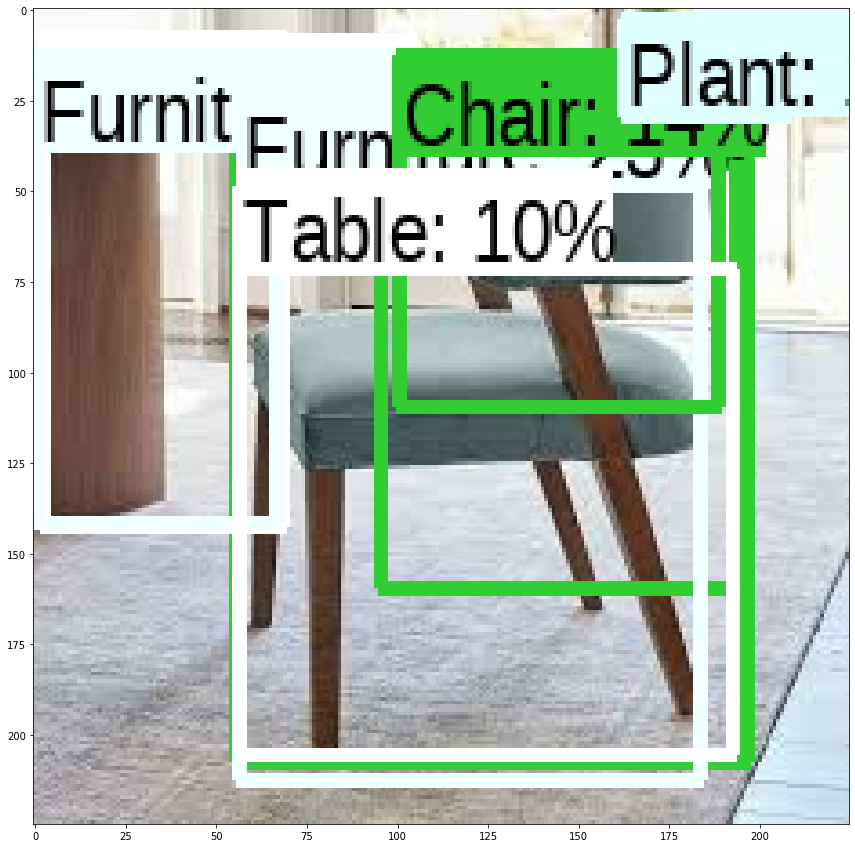

In [19]:
run_detector(detector, img_path)